In this notebook we split dataset to train and testset. This basic task is done to ensure that we use the same dataset in all trainings. This is done, on the other hand, to ensure that we can probebly analyse results and do case studies.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
import datetime as dt
import boto3, yaml
from datetime import timedelta

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize, MinMaxScaler
from imblearn.over_sampling import SMOTE
import sys,os

from joblib import dump, load

util_path = os.path.abspath(os.path.join(os.path.pardir, '../sasse-polygon-process/lib'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)
    
from config import read_options

sns.set()
sns.set_style("whitegrid")
%matplotlib inline

In [21]:
class Options(): pass

options = Options()
options.config_filename = '../cnf/rfc.ini'
options.config_name = 'forest'
read_options(options)

options_thin = Options()
options_thin.config_filename = '../cnf/rfc.ini'
options_thin.config_name = 'thin'
read_options(options_thin)

In [3]:
def save_model(model, fname, remote_name):
    """ Save model and upload it to bucket """
    
    save_path = os.path.dirname(os.path.abspath(fname))

    if not os.path.exists(save_path):
        os.mkdir(save_path)
    
    dump(model, fname)
    
    s3 = boto3.resource('s3')
    s3.meta.client.upload_file(fname, 'fmi-asi-sasse-assets', remote_name)

In [22]:
def get_data(name, options, scaler_name, scaler=None, verbose=False):
    """ Read and normalise data """
    
    data = pd.read_csv(name)
    data = data.loc[data['weather_parameter'] == 'WindGust'].fillna(0)
    
    label = options.label[0]
    
    data['point_in_time'] = pd.to_datetime(data['point_in_time'])        
    data['week'] = data['point_in_time'].dt.week

    missing = list(set(options.feature_params + options.meta_params + options.label)-set(data.columns.values))
    if len(missing) > 0:
        raise ValueError("Missing parameter(s) {}".format(','.join(missing)))
    
    y = data.loc[:, options.label].values.ravel()
    data_train, data_test, _, __ = train_test_split(data, y, stratify=y)        
            
    # For analysis
    if verbose:
        for c in [1,2,3]:
            print('Dates in testset class {}:'.format(c))
            for i, row in data_test[(data_test['class']==c)].iterrows():
                print(row.point_in_time, end=',')
            print("\n")    
    
    X_train = data_train.loc[:, options.feature_params]
    y_train = data_train.loc[:, options.label]
    meta_train = data_train.loc[:, options.meta_params]

    X_test = data_test.loc[:, options.feature_params]
    y_test = data_test.loc[:, options.label]
    meta_test = data_test.loc[:, options.meta_params]
    
    # Scale
    if scaler is None:
        scaler = StandardScaler()      
    
    try:
        X_train = pd.DataFrame(scaler.transform(X_train), columns=options.feature_params)
    except:
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=options.feature_params)
        save_model(scaler, '../data/models/scaler/{}.joblib'.format(scaler_name), 'models/scaler/{}.joblib'.format(scaler_name))

    X_test = pd.DataFrame(scaler.transform(X_test), columns=options.feature_params)
            
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(X_train, y_train)
    
    train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True), meta_train.reset_index(drop=True)], axis=1)
    test = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True), meta_test.reset_index(drop=True)], axis=1)
    res = pd.concat([pd.DataFrame(X_res, columns=options.feature_params), pd.DataFrame(y_res, columns=options.label)], axis=1)
    
    return train, test, res, scaler

In [5]:
def cut_classes(dataset, classes, max_size, label): 
    """ Decrease dataset size by cutting requested classes smaller """
    
    # Cherry picked classes
    class_dfs = []
    for c in classes: 
        picked_data = dataset.loc[(dataset.loc[:,label] == c),:]
        class_dfs.append(picked_data.sample(n=min(len(picked_data), max_size)))

    # Concat
    data = pd.concat(class_dfs)
    return data

In [6]:
def plot_class_hist(data_train, data_test,title='', num_classes=4, fontsize=10):

    fig, ax = plt.subplots(figsize=(15,4))
    plt.rc('font', size=fontsize)
    tickfontsize=0.8*fontsize
    
    ##### Plot 1
    ax = plt.subplot(1,2,1)

    data_train.loc[:, 'class'].hist(ax=ax, color='xkcd:tea')

    ymin, ymax = ax.get_ylim()
    ax.set_ylim((ymin, ymax*1.1))
    
    plt.title('Train set', fontsize=fontsize)
    plt.ylabel('Record count', fontsize=fontsize)
    plt.xlabel('Class', fontsize=fontsize)
    plt.yticks(fontsize=tickfontsize)
    plt.xticks(fontsize=tickfontsize)

    i=0
    for rect in ax.patches:
        if i%(num_classes-1) == 0:
            height = rect.get_height()
            ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                        xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 
        i+=1
    
    plt.grid(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    ##### Plot 2 
    
    ax = plt.subplot(1,2,2)
    data_test.loc[:, 'class'].hist(ax=ax, color='xkcd:dust')    
    
    ymin, ymax = ax.get_ylim()
    ax.set_ylim((ymin, ymax*1.1))
    
    plt.grid(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.title('Test set', fontsize=fontsize)
    plt.ylabel('Record count', fontsize=fontsize)
    plt.xlabel('Class', fontsize=fontsize)
    plt.yticks(fontsize=tickfontsize)
    plt.xticks(fontsize=tickfontsize)
    
    i=0
    for rect in ax.patches:
        if i%(num_classes-1) == 0:
            height = rect.get_height()
            ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                        xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 
        i+=1
    
    plt.suptitle(title, x=.22, y=1.03)

In [7]:
def save_dataset(datasets):
    """ Save data to local filesystem and S3 """
    
    for name, data in datasets:
        filename = '../data/{}.csv'.format(name)
        remote_name = 'data/{}.csv'.format(name)

        data.to_csv(filename, index=False)
        
        s3 = boto3.resource('s3')
        s3.meta.client.upload_file(filename, 'fmi-asi-sasse-assets', remote_name)

# Loiste - JSE

In [23]:
print('All params:')
train_all_loiste, test_all_loiste, res_all_loiste, scaler_loiste_jse_all = get_data('../data/classification_dataset_loiste_jse_forest.csv', options, 'scaler_loiste_jse_all', verbose=True)

print("\n")
print('Thin setup:')
train_thin_loiste, test_thin_loiste, res_thin_loiste, scaler_loiste_jse_thin = get_data('../data/classification_dataset_loiste_jse_forest.csv', options_thin, 'scaler_loiste_jse_thin', verbose=True)

train_small_loiste = cut_classes(train_all_loiste, [0,1,2,3], 1000, options.label[0]) 
train_thin_small_loiste = cut_classes(train_thin_loiste, [0,1,2,3], 1000, options.label[0]) 

train_tiny_loiste = cut_classes(train_all_loiste, [0,1,2,3], 500, options.label[0]) 
train_thin_tiny_loiste = cut_classes(train_thin_loiste, [0,1,2,3], 500, options.label[0]) 

All params:
Dates in testset class 1:
2014-03-08 05:00:00+00:00,2016-04-27 08:00:00+00:00,2015-06-07 13:00:00+00:00,2015-05-23 16:00:00+00:00,2018-09-13 08:00:00+00:00,2017-03-27 15:00:00+00:00,2017-06-30 13:00:00+00:00,2012-01-13 14:00:00+00:00,2015-06-03 15:00:00+00:00,2015-05-23 10:00:00+00:00,2018-10-05 10:00:00+00:00,2017-06-02 13:00:00+00:00,2010-09-03 10:00:00+00:00,2012-06-02 19:00:00+00:00,2016-08-27 14:00:00+00:00,2015-10-02 18:00:00+00:00,2017-04-26 21:00:00+00:00,2012-09-17 19:00:00+00:00,2012-06-02 12:00:00+00:00,2017-04-26 11:00:00+00:00,2018-06-05 00:00:00+00:00,2012-02-06 13:00:00+00:00,2013-12-13 03:00:00+00:00,2018-06-05 01:00:00+00:00,2016-09-29 22:00:00+00:00,2011-12-02 05:00:00+00:00,2014-09-25 00:00:00+00:00,2015-04-08 20:00:00+00:00,2011-11-26 14:00:00+00:00,2015-06-16 11:00:00+00:00,2012-01-13 10:00:00+00:00,2013-11-17 08:00:00+00:00,2015-03-31 08:00:00+00:00,2010-07-23 09:00:00+00:00,2016-12-05 10:00:00+00:00,2014-03-14 13:00:00+00:00,2011-10-19 04:00:00+00:00,

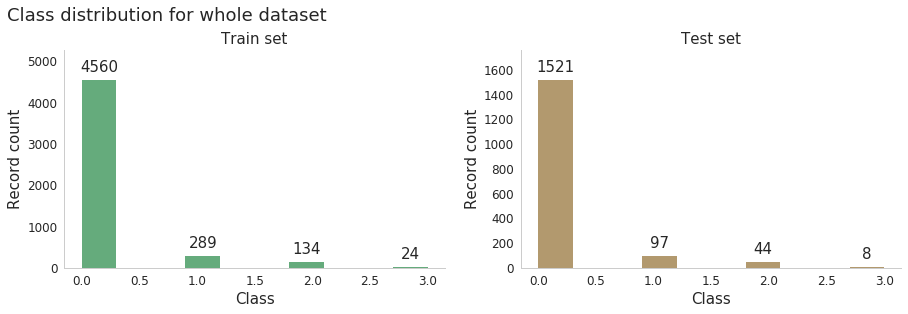

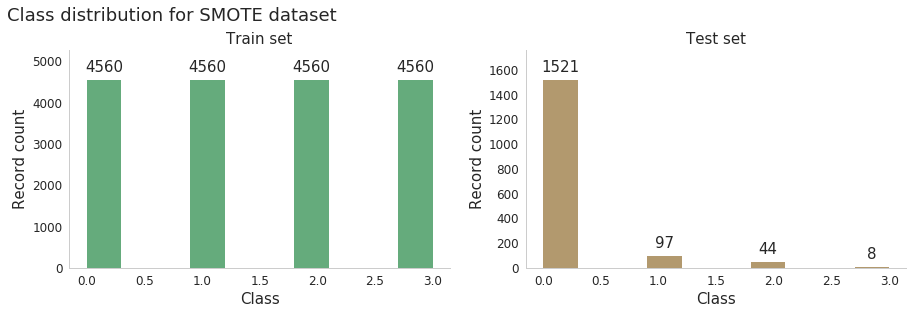

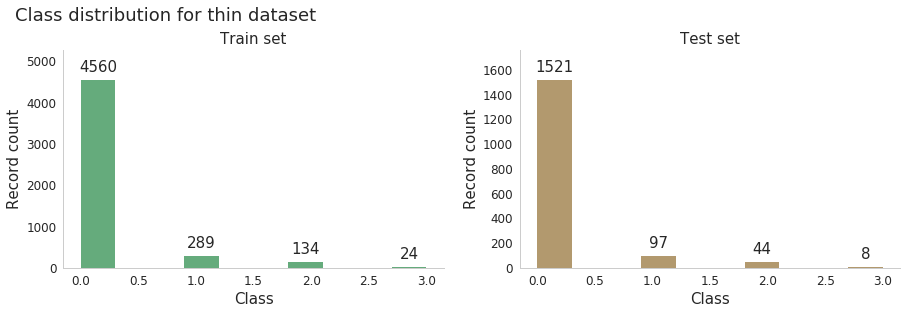

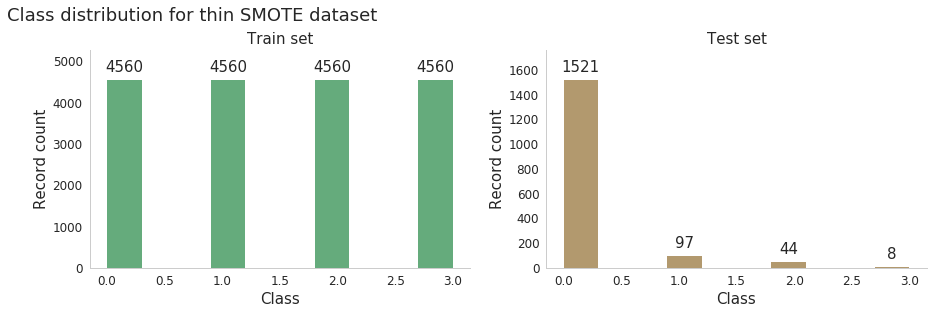

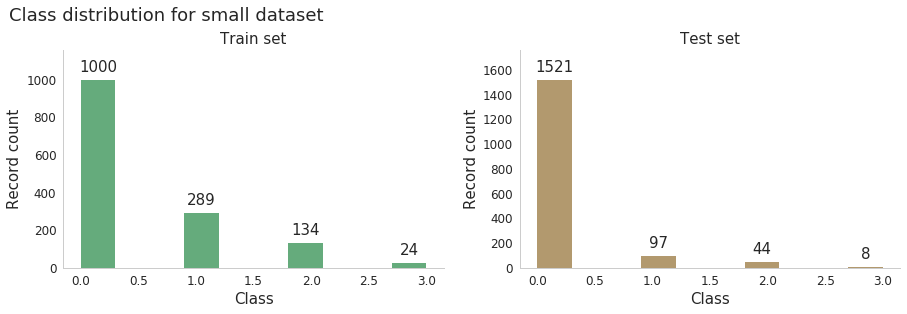

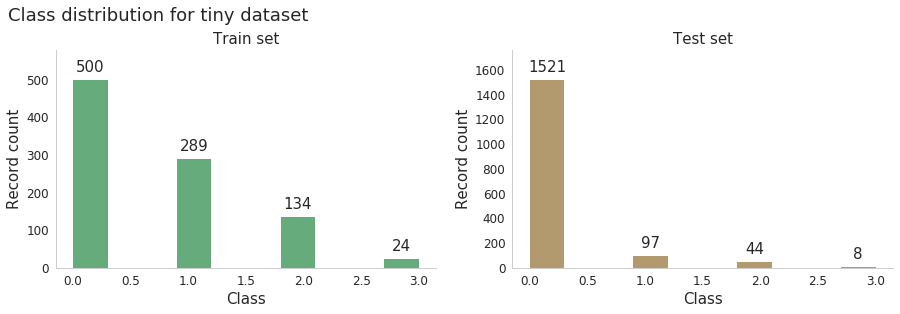

In [24]:
plot_class_hist(train_all_loiste, test_all_loiste, title='Class distribution for whole dataset', fontsize=15)
plot_class_hist(res_all_loiste, test_all_loiste, title='Class distribution for SMOTE dataset', fontsize=15)

plot_class_hist(train_thin_loiste, test_thin_loiste, title='Class distribution for thin dataset', fontsize=15)
plot_class_hist(res_thin_loiste, test_thin_loiste, title='Class distribution for thin SMOTE dataset', fontsize=15)

plot_class_hist(train_small_loiste, test_all_loiste, title='Class distribution for small dataset', fontsize=15)
plot_class_hist(train_tiny_loiste, test_all_loiste, title='Class distribution for tiny dataset', fontsize=15)

In [25]:
datasets = [('loiste_jse_all_train', train_all_loiste), 
            ('loiste_jse_all_test', test_all_loiste), 
            ('loiste_jse_all_res', res_all_loiste),
            ('loiste_jse_thin_train', train_thin_loiste),
            ('loiste_jse_thin_test', test_thin_loiste),
            ('loiste_jse_thin_res', res_thin_loiste),
            ('loiste_jse_small_train', train_small_loiste),
            ('loiste_jse_small_thin_train', train_thin_small_loiste),
            ('loiste_jse_tiny_train', train_tiny_loiste),
            ('loiste_jse_tiny_thin_train', train_thin_tiny_loiste)
           ]
save_dataset(datasets)

# Energiateollisuus

In [26]:
class Options(): pass

options_ene = Options()
options_ene.config_filename = '../cnf/rfc.ini'
options_ene.config_name = 'forest_energiateollisuus'
read_options(options_ene)

options_ene_thin = Options()
options_ene_thin.config_filename = '../cnf/rfc.ini'
options_ene_thin.config_name = 'thin_energiateollisuus'
read_options(options_ene_thin)

In [27]:
print('All params:')
train_all_energiateollisuus, test_all_energiateollisuus, res_all_energiateollisuus, scaler_energiateollisuus_all = get_data('../data/classification_dataset_energiateollisuus_forest.csv', options_ene, 'scaler_energiateollisuus_all', verbose=True)

print("\n")
print('Thin setup:')
train_thin_energiateollisuus, test_thin_energiateollisuus, res_thin_energiateollisuus, scaler_energiateollisuus_thin = get_data('../data/classification_dataset_energiateollisuus_forest.csv', options_ene_thin, 'scaler_energiateollisuus_thin', verbose=True)

train_small_energiateollisuus = cut_classes(train_all_energiateollisuus, [0,1,2,3], 1000, options_ene.label[0]) 
train_thin_small_energiateollisuus = cut_classes(train_thin_energiateollisuus, [0,1,2,3], 1000, options_ene_thin.label[0]) 

train_tiny_energiateollisuus = cut_classes(train_all_energiateollisuus, [0,1,2,3], 500, options_ene.label[0]) 
train_thin_tiny_energiateollisuus = cut_classes(train_thin_energiateollisuus, [0,1,2,3], 500, options_ene_thin.label[0]) 

All params:
Dates in testset class 1:
2015-11-28 13:00:00+00:00,2018-10-05 09:00:00+00:00,2018-03-24 08:00:00+00:00,2015-09-29 21:00:00+00:00,2018-06-04 14:00:00+00:00,2016-08-16 01:00:00+00:00,2018-06-22 20:00:00+00:00,2017-01-12 15:00:00+00:00,2016-02-21 12:00:00+00:00,2018-07-29 10:00:00+00:00,2016-08-09 06:00:00+00:00,2015-02-08 10:00:00+00:00,2015-06-02 08:00:00+00:00,2017-10-25 05:00:00+00:00,2012-01-26 20:00:00+00:00,2018-10-21 07:00:00+00:00,2016-11-19 08:00:00+00:00,2017-12-08 13:00:00+00:00,2018-01-25 02:00:00+00:00,2016-08-16 13:00:00+00:00,2017-06-21 11:00:00+00:00,2018-08-21 08:00:00+00:00,2017-12-08 05:00:00+00:00,2018-10-09 11:00:00+00:00,2017-10-30 07:00:00+00:00,2015-12-20 22:00:00+00:00,2018-09-12 19:00:00+00:00,2015-06-02 12:00:00+00:00,2016-12-21 13:00:00+00:00,2018-08-19 00:00:00+00:00,2017-12-02 15:00:00+00:00,2012-01-14 11:00:00+00:00,2012-11-20 08:00:00+00:00,2018-10-14 11:00:00+00:00,2017-01-11 04:00:00+00:00,2017-12-07 17:00:00+00:00,2018-01-14 19:00:00+00:00,

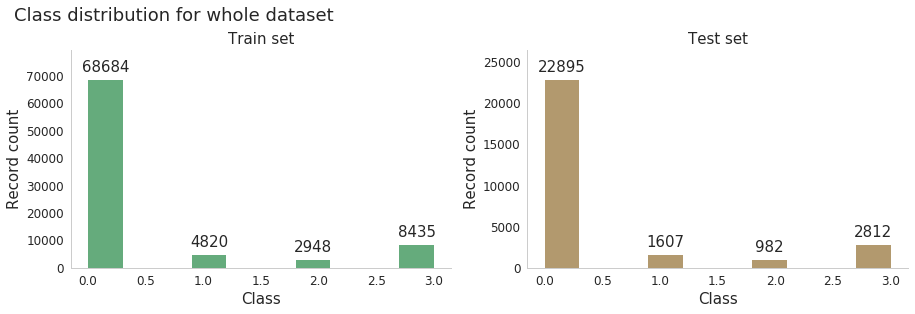

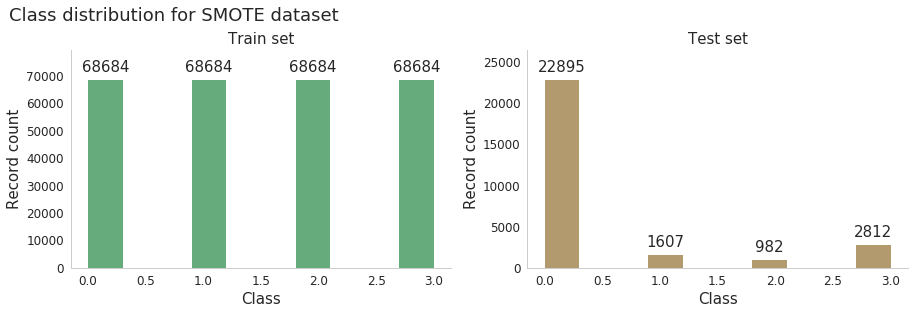

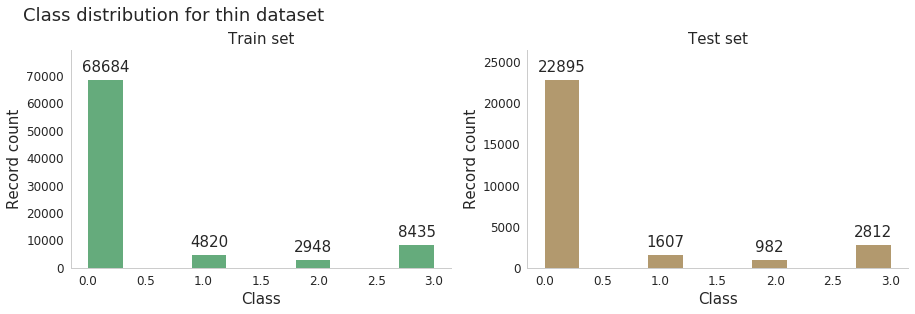

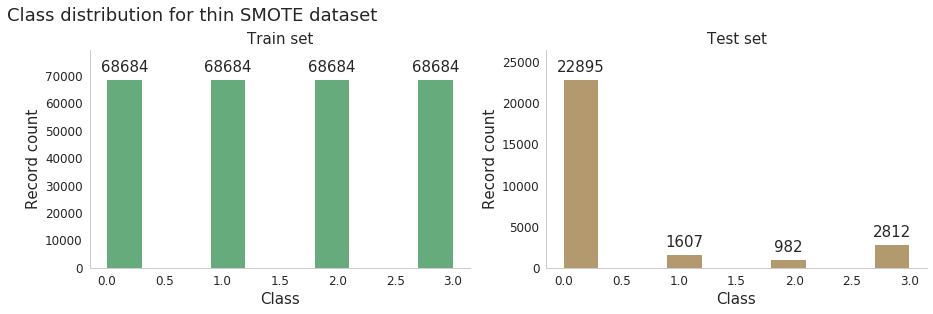

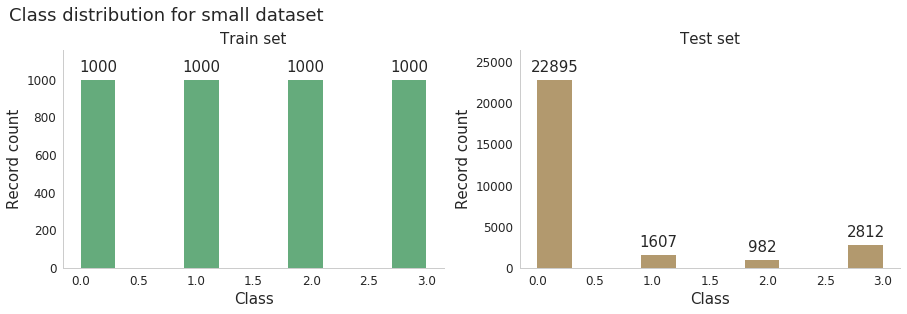

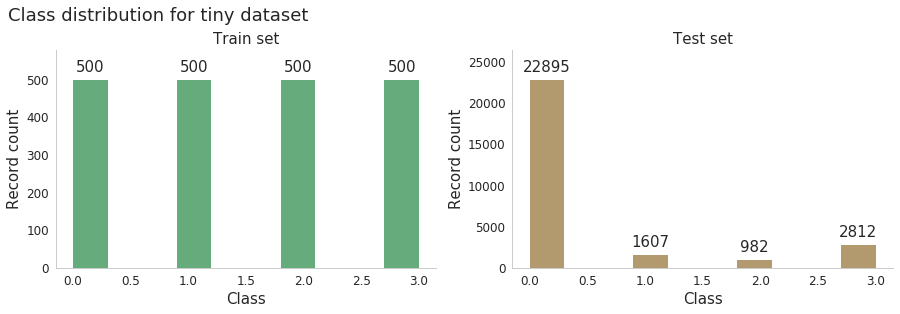

In [28]:
plot_class_hist(train_all_energiateollisuus, test_all_energiateollisuus, title='Class distribution for whole dataset', fontsize=15)
plot_class_hist(res_all_energiateollisuus, test_all_energiateollisuus, title='Class distribution for SMOTE dataset', fontsize=15)

plot_class_hist(train_thin_energiateollisuus, test_thin_energiateollisuus, title='Class distribution for thin dataset', fontsize=15)
plot_class_hist(res_thin_energiateollisuus, test_thin_energiateollisuus, title='Class distribution for thin SMOTE dataset', fontsize=15)

plot_class_hist(train_small_energiateollisuus, test_all_energiateollisuus, title='Class distribution for small dataset', fontsize=15)
plot_class_hist(train_tiny_energiateollisuus, test_all_energiateollisuus, title='Class distribution for tiny dataset', fontsize=15)

In [29]:
datasets = [('energiateollisuus_all_train', train_all_energiateollisuus), 
            ('energiateollisuus_all_test', test_all_energiateollisuus), 
            ('energiateollisuus_all_res', res_all_energiateollisuus),
            ('energiateollisuus_thin_train', train_thin_energiateollisuus),
            ('energiateollisuus_thin_test', test_thin_energiateollisuus),
            ('energiateollisuus_thin_res', res_thin_energiateollisuus),
            ('energiateollisuus_small_train', train_small_energiateollisuus),
            ('energiateollisuus_small_thin_train', train_thin_small_energiateollisuus),
            ('energiateollisuus_tiny_train', train_tiny_energiateollisuus),
            ('energiateollisuus_tiny_thin_train', train_thin_tiny_energiateollisuus),
           ]
save_dataset(datasets)